# Explore Experiment-Wise Queries of Results in the Utah Organoids Pipeline


### **Overview**

This notebook demonstrates how to query, process, and visualize LFP power band data from the Utah Organoids pipeline. It includes selection of LFP sessions, construction of aligned power band matrices, and visualizations of temporal and pharmacological dynamics.

**_Note:_**

- This notebook uses example entries and visualizations. Replace them with your actual experiment keys and analyses.

### **Key Steps**

- **Setup**

- **Step 1: Query Experiments and Durations**

- **Step 2: Select Non-Overlapping LFP Sessions of Interest**

- **Step 3: Assemble Power Data into a Unified NumPy Array**

- **Step 4: Visualize LFP Sessions with Drug Conditions**

- **Step 5: Normalize Power Traces Per Electrode**

- **Step 6: Visualize Stacked Band Power Traces Per Electrode**

#### **Setup**


In [1]:
import os

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")

In [2]:
import datajoint as dj
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict, defaultdict


In [3]:
from workflow.pipeline import culture, ephys, probe, analysis

[2025-04-23 18:32:48,493][INFO]: Connecting milagros@db.datajoint.com:3306
[2025-04-23 18:32:49,810][INFO]: Connected milagros@db.datajoint.com:3306


### **Step 1: Query Experiments and Durations**

Fetch experiments and their total durations in hours using start and end timestamps.

In [4]:
exp_duration_query = (culture.Experiment).proj(
    exp_duration_hour="TIMESTAMPDIFF(HOUR, CAST(experiment_start_time AS DATETIME), CAST(experiment_end_time AS DATETIME))",
    drug_name="drug_name",
)
exp_duration_query

*organoid_id    *experiment_start_time    drug_name       exp_duration_hour    
+-------------+ +-----------------------+ +-------------+ +-------------------+
E01             2024-08-30 19:43:00       Control         0                    
E02             2024-08-30 19:43:00       Control         0                    
E03             2024-08-30 19:43:00       Control         0                    
E04             2024-08-30 19:43:00       Control         0                    
E09             2024-10-30 13:09:00       Control         0                    
E10             2024-10-30 13:09:00       Control         0                    
E11             2024-10-30 13:09:00       Control         0                    
E12             2024-10-30 13:09:00       Control         0                    
MB01            2024-08-30 19:00:00       Control         0                    
MB02            2024-08-30 19:00:00       Control         0                    
MB03            2024-08-30 19:00:00       Control         0                    
MB04            2024-08-30 19:00:00       Control         0                    
MB05            2024-09-07 14:49:00       Control         0                    
MB06            2024-09-07 14:49:00       Control         0                    
MB07            2024-09-07 14:49:00       Control         0                    
MB08            2024-09-07 14:49:00       Control         0                    
O09             2023-05-03 17:33:00       Control         354                  
O09             2023-05-18 12:25:00       4-AP            5                    
O09             2023-05-18 18:15:00       No Drug         15                   
O09             2023-05-19 09:30:00       Bicuculline     6                    
   ...
 (Total: 116)

### **Step 2: Select Non-Overlapping LFP Sessions of Interest**


Select sessions for a specific organoid (e.g., "O13") with durations > 1 hour.

In [5]:
organoid_id = "O13"
organoid_query = (
    exp_duration_query & "exp_duration_hour > 1" & f'organoid_id="{organoid_id}"'
)
organoid_query

*organoid_id    *experiment_start_time    drug_name        exp_duration_hour    
+-------------+ +-----------------------+ +--------------+ +-------------------+
O13             2023-05-25 19:18:00       Control          335                  
O13             2023-06-08 19:05:00       4-AP             4                    
O13             2023-06-08 23:35:00       No Drug          10                   
O13             2023-06-09 10:20:00       Bicuculline      5                    
O13             2023-06-09 15:40:00       Tetrodotoxin     22                   
 (Total: 5)

Select the ephys sessions for LFP analysis:

In [6]:
lfp_query = ephys.EphysSession & organoid_query & 'session_type="lfp"'
lfp_query

*organoid_id    *experiment_start_time    *insertion_number    *start_time             *end_time               session_type    
+-------------+ +-----------------------+ +------------------+ +---------------------+ +---------------------+ +--------------+
O13             2023-06-08 19:05:00       0                    2023-06-08 19:05:00     2023-06-08 19:20:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 19:10:00     2023-06-08 19:15:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 19:20:00     2023-06-08 19:35:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 19:35:00     2023-06-08 19:50:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 19:50:00     2023-06-08 20:05:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 20:05:00     2023-06-08 20:20:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 20:20:00     2023-06-08 20:35:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 20:35:00     2023-06-08 20:50:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 20:50:00     2023-06-08 21:05:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 21:05:00     2023-06-08 21:20:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 21:20:00     2023-06-08 21:35:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 21:35:00     2023-06-08 21:50:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 21:50:00     2023-06-08 22:05:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 22:05:00     2023-06-08 22:20:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 22:20:00     2023-06-08 22:35:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 22:35:00     2023-06-08 22:50:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 22:50:00     2023-06-08 23:05:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 23:05:00     2023-06-08 23:20:00     lfp             
O13             2023-06-08 19:05:00       0                    2023-06-08 23:20:00     2023-06-08 23:35:00     lfp             
O13             2023-06-08 23:35:00       0                    2023-06-08 23:35:00     2023-06-08 23:50:00     lfp             
   ...
 (Total: 172)

From these sessions, extract the subset of non-overlapping sessions that maximizes total recording time, count the number of gaps between consecutive sessions, and store the selected session keys for downstream data access.

In [7]:
sessions = (
    (ephys.LFP.Trace * organoid_query & lfp_query)
    .proj("start_time", "end_time", "experiment_start_time", "drug_name")
    .fetch(as_dict=True, order_by="start_time")
)

In [8]:
# Convert to list of intervals with duration
intervals = []
for s in sessions:
    start = s["start_time"]
    end = s["end_time"]
    duration = (end - start).total_seconds() / 3600  # Convert to hours
    intervals.append({"start": start, "end": end, "duration": duration, "session": s})


# Find non-overlapping intervals
def find_max_non_overlapping(intervals):
    # Sort by end time
    intervals.sort(key=lambda x: x["end"])

    n = len(intervals)
    dp = [0] * n  # dp[i] stores max duration up to interval i
    selected = [False] * n

    # Base case
    dp[0] = intervals[0]["duration"]
    selected[0] = True

    # For each interval
    for i in range(1, n):
        # Find last non-overlapping interval
        last = -1
        for j in range(i - 1, -1, -1):
            if intervals[j]["end"] <= intervals[i]["start"]:
                last = j
                break

        # Take maximum of including current interval or excluding it
        incl = intervals[i]["duration"]
        if last != -1:
            incl += dp[last]

        if incl > dp[i - 1]:
            dp[i] = incl
            selected[i] = True
        else:
            dp[i] = dp[i - 1]
            selected[i] = False

    # Reconstruct solution
    result = []
    i = n - 1
    while i >= 0:
        if selected[i]:
            result.append(intervals[i])
        i -= 1

    return result[::-1]  # Reverse to get chronological order


# Get optimal non-overlapping sessions
optimal_intervals = find_max_non_overlapping(intervals)

# Count gaps between intervals
num_gaps = 0
for i in range(len(optimal_intervals) - 1):
    if optimal_intervals[i]["end"] != optimal_intervals[i + 1]["start"]:
        num_gaps += 1

# Create list of keys for further querying
selected_session_keys = []
for interval in optimal_intervals:
    session = interval["session"]
    key = {
        "organoid_id": session["organoid_id"],
        "experiment_start_time": session["experiment_start_time"],
        "start_time": session["start_time"],
        "end_time": session["end_time"],
    }
    selected_session_keys.append(key)

print("Selected session keys for further querying:")
for key in selected_session_keys:
    print(f"\n Session key:")
    for k, v in key.items():
        print(f"{k}: {v}")

print(f"\n Total number of non-overlapping sessions: {len(selected_session_keys)}")
print(f"Number of gaps between sessions: {num_gaps}")

Selected session keys for further querying:

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 19:05:00
end_time: 2023-06-08 19:20:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 19:20:00
end_time: 2023-06-08 19:35:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 19:35:00
end_time: 2023-06-08 19:50:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 19:50:00
end_time: 2023-06-08 20:05:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 20:05:00
end_time: 2023-06-08 20:20:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 20:20:00
end_time: 2023-06-08 20:35:00

 Session key:
organoid_id: O13
experiment_start_time: 2023-06-08 19:05:00
start_time: 2023-06-08 20:35:00
end_time: 2023-06-08 20:50:

Calculate the total duration of the selected sessions.

In [9]:
selected_sessions_query = (
    culture.Experiment * ephys.EphysSession & selected_session_keys
).proj(
    duration="TIMESTAMPDIFF(MINUTE, CAST(start_time AS DATETIME), CAST(end_time AS DATETIME))"
)

total_duration = selected_sessions_query.fetch("duration").sum()
total_duration_hours = total_duration / 60
print(f"Total duration of selected sessions: {total_duration_hours} hours")

Total duration of selected sessions: 42.75 hours


Fetch the LFP data for the selected sessions.

In [10]:
entries = (
    analysis.LFPSpectrogram.ChannelPower * culture.Experiment
    & selected_sessions_query
    & 'drug_name != "Control"'
).fetch(
    "band_name",
    "electrode",
    "power",
    "start_time",
    "end_time",
    "drug_name",
    as_dict=True,
)
len(entries)

29925

In [11]:
entries[0]

{'start_time': datetime.datetime(2023, 6, 8, 19, 5),
 'end_time': datetime.datetime(2023, 6, 8, 19, 20),
 'electrode': 0,
 'band_name': 'alpha',
 'power': array([0.02090651, 0.13667926, 0.05932646, ..., 0.02457348, 0.04335007,
        0.01916634]),
 'drug_name': '4-AP'}

### **Step 3: Assemble Power Data into a Unified NumPy Array**



- Fetch power band data from `LFPSpectrogram.ChannelPower` for each band and electrode.

- Organize data by session → band → electrode.

- Construct a **3D array full_array of shape (time, bands, electrodes)**, concatenating sessions chronologically.

- Insert NaN gaps between sessions when needed.

- Track start/end indices and drug name for each session.

In [12]:
from collections import defaultdict
import numpy as np

# 1. Organize entries by session directly
entries_by_session = defaultdict(
    lambda: defaultdict(dict)
)  # (start, end) → band → electrode → power

for entry in entries:
    key = (entry["start_time"], entry["end_time"])
    band = entry["band_name"].lower()
    elec = entry["electrode"]
    entries_by_session[key][band][elec] = entry["power"]

# 2. Extract band info and session shape
bands = sorted({e["band_name"].lower() for e in entries})
band_idx = {b: i for i, b in enumerate(bands)}
n_bands = len(bands)
n_electrodes = 32  # set based on your setup

# Get sample length from first power array
sample_len = None
for session_data in entries_by_session.values():
    for band_data in session_data.values():
        for power_array in band_data.values():
            sample_len = power_array.shape[0]
            break
        break
    break

# 3. Create the numpy array and map session metadata
sampling_rate = None
cursor = 0
last_end = None
all_chunks = []
session_sample_ranges_with_drug = []

# Map each session to drug name (for visualization)
session_to_drug = {(e["start_time"], e["end_time"]): e["drug_name"] for e in entries}

# Process all sessions in chronological order
for (start, end), band_elec_data in sorted(
    entries_by_session.items(), key=lambda x: x[0][0]
):
    # Get this session's sample length
    session_sample_len = None
    for band_data in band_elec_data.values():
        for power_array in band_data.values():
            session_sample_len = power_array.shape[0]
            break
        break
    if session_sample_len is None:
        continue  # skip empty session

    # Compute sampling rate once
    dur_hr = (end - start).total_seconds() / 3600
    if sampling_rate is None:
        sampling_rate = session_sample_len / dur_hr

    # Allocate chunk for current session
    chunk = np.full((session_sample_len, n_bands, n_electrodes), np.nan)

    # Fill chunk with data
    for band, elec_data in band_elec_data.items():
        b_idx = band_idx[band]
        for e_idx, power_trace in elec_data.items():
            chunk[:, b_idx, e_idx] = power_trace

    # Add gap if needed
    if last_end:
        gap_hr = (start - last_end).total_seconds() / 3600
        if gap_hr > 0.001:
            gap_len = int(np.round(gap_hr * sampling_rate))
            all_chunks.append(np.full((gap_len, n_bands, n_electrodes), np.nan))
            cursor += gap_len

    # Register metadata
    start_idx = cursor
    end_idx = cursor + session_sample_len
    drug = session_to_drug.get((start, end), "Unknown")
    session_sample_ranges_with_drug.append((start_idx, end_idx, drug))
    cursor = end_idx

    all_chunks.append(chunk)
    last_end = end


# 4. Create the final unified array
full_array = np.concatenate(all_chunks, axis=0)
full_array.shape

(308400, 7, 32)

### **Step 4: Visualize LFP Sessions with Drug Conditions**

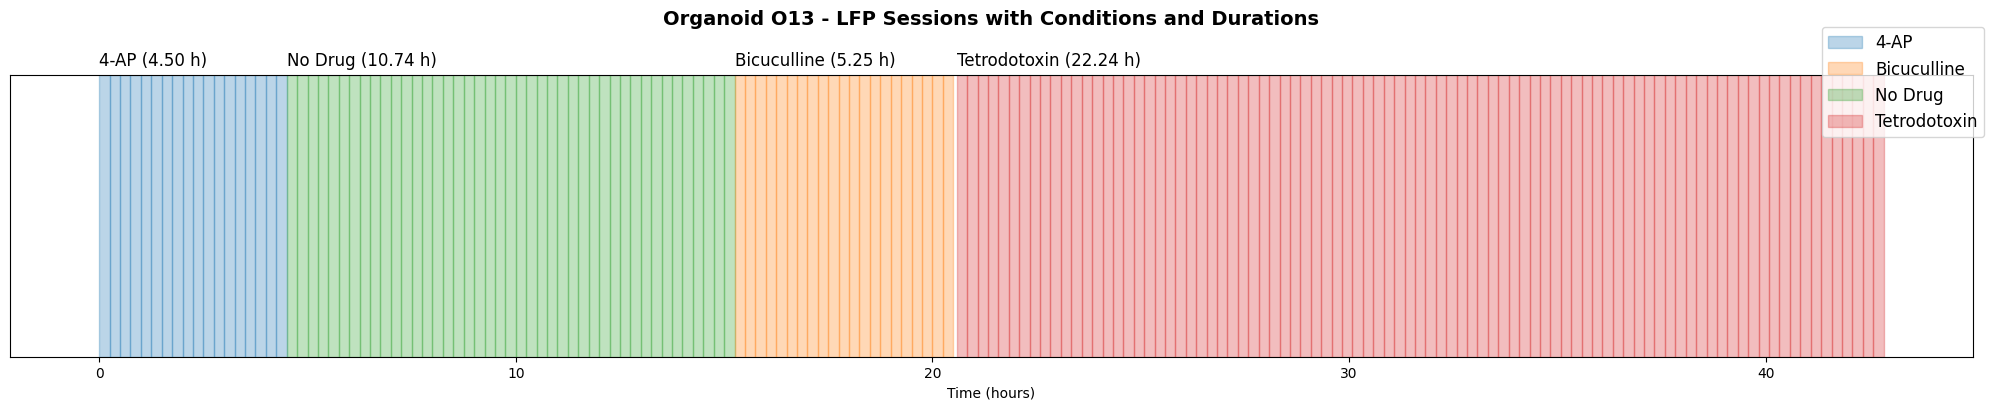

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict, OrderedDict
import numpy as np

# Generate color map for drugs
all_drugs = sorted({drug for _, _, drug in session_sample_ranges_with_drug})
drug_colors = {drug: plt.cm.tab10(i) for i, drug in enumerate(all_drugs)}

# Create time axis in hours
time_axis = np.arange(full_array.shape[0]) / sampling_rate

# Compute durations and first occurrences
drug_durations = defaultdict(float)
drug_first_occurrence = OrderedDict()

for start_idx, end_idx, drug in session_sample_ranges_with_drug:
    start_hr = time_axis[start_idx]
    end_hr = time_axis[end_idx - 1]
    duration = end_hr - start_hr
    drug_durations[drug] += duration
    if drug not in drug_first_occurrence:
        drug_first_occurrence[drug] = start_hr

# Plot the data
fig, ax = plt.subplots(figsize=(20, 4))

# Highlight session ranges with drug colors
for start_idx, end_idx, drug in session_sample_ranges_with_drug:
    ax.axvspan(
        time_axis[start_idx],
        time_axis[end_idx - 1],
        color=drug_colors[drug],
        alpha=0.3,
        label=drug,
    )

# Add drug labels on top
for drug, start_hr in drug_first_occurrence.items():
    duration = drug_durations[drug]
    label = f"{drug} ({duration:.2f} h)"
    ax.text(
        start_hr,
        1.02,
        label,
        ha="left",
        va="bottom",
        fontsize=12,
        transform=ax.get_xaxis_transform(),
    )

# Add legend
handles = [Patch(color=drug_colors[d], alpha=0.3, label=d) for d in all_drugs]
ax.legend(handles=handles, loc="upper right", bbox_to_anchor=(1.01, 1.2), fontsize=12)

# Final touches
ax.set_xlabel("Time (hours)")
ax.set_title(
    f"Organoid {organoid_id} - LFP Sessions with Conditions and Durations",
    y=1.15,
    fontsize=14,
    fontweight="bold",
)

ax.set_yticks([])
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.show()


This contextual plot provides a reference to align later electrode-level band activity plots.

### **Step 5: Normalize Power Traces Per Electrode**

- For each electrode and band, normalize values across time to a [0, 1] range using the 1st and 99th percentiles.

- This step enables direct comparison across bands and electrodes by removing scale differences.

- Preserve session gaps by filling them with NaNs in the normalized array norm_power.

In [14]:
# Normalize power values per electrode
norm_power = np.zeros_like(full_array)  # Shape: (time, bands, electrodes)
for e in range(full_array.shape[2]):  # Iterate over electrodes
    for b in range(n_bands):
        trace = full_array[:, b, e]
        p1 = np.nanpercentile(trace, 1)
        p99 = np.nanpercentile(trace, 99)
        if p99 > p1:
            norm_power[:, b, e] = np.clip((trace - p1) / (p99 - p1), 0, 1)
        else:
            norm_power[:, b, e] = 0

# Identify gaps between sessions
gaps = [
    (session_sample_ranges_with_drug[i - 1][1], session_sample_ranges_with_drug[i][0])
    for i in range(1, len(session_sample_ranges_with_drug))
    if session_sample_ranges_with_drug[i][0] > session_sample_ranges_with_drug[i - 1][1]
]

# Assign NaN to gaps
for start_idx, end_idx in gaps:
    norm_power[start_idx:end_idx, :, :] = np.nan

/Users/milagros/miniconda/envs/utah_organoids/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


In [15]:
norm_power.shape

(308400, 7, 32)

### **Step 6: Visualize Stacked Band Power Traces Per Electrode**

For each electrode:

- Plot all 7 bands using temporal smoothing (condense_array) to reduce noise and number of points.

- Apply log-scaled vertical stacking to separate bands visually (Delta on top, HG2 on bottom).

- Overlay vertical dashed lines to indicate the start time of each drug (from drug_first_occurrence).

- Label each drug on the x-axis for clarity.

Fetch band info in desired physiological order:

In [16]:
desired_order = ["delta", "theta", "alpha", "beta", "gamma", "highgamma1", "highgamma2"]
bands_data = {
    row["band_name"]: row
    for row in analysis.SpectralBand.fetch(as_dict=True)
    if row["band_name"] in desired_order
}
bands = desired_order
n_bands = len(bands)

# Labels and colors (aligned to `bands`)
lfp_labels = [b.capitalize().replace("highgamma", "HG") for b in bands]
lfp_colors = [
    "#ad2bea",
    "#4d3ff8",
    "#39cabb",
    "#53e53a",
    "#e3e12c",
    "#f7a740",
    "#ed3838",
][:n_bands]


`condense_array()` averages over n_points windows, reducing noise while preserving key dynamics. Downsampling will reduce the number of time points (noise) by averaging over fixed-size chunks of the original data. This keeps the overall trends while making plots more efficient and readable:

In [17]:
# Downsample and stacking config
n_points = 600
band_log_offsets = np.logspace(2, 0, n_bands)  # Delta gets highest offset

# Sampling and time axis
sampling_rate_hz = 2.5
time_axis = np.arange(norm_power.shape[0]) / (sampling_rate_hz * 3600)  # in hours
n_electrodes = norm_power.shape[2]


# --- Downsampling with time alignment ---
def condense_array(array, time_vector, n_points):
    total_len = array.shape[0]
    chunk_size = total_len // n_points
    condensed = []
    time_centers = []
    for i in range(n_points):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_points - 1 else total_len
        chunk = array[start:end, :]
        chunk_mean = np.nanmean(chunk, axis=0)
        chunk_time = np.nanmean(time_vector[start:end])
        condensed.append(chunk_mean)
        time_centers.append(chunk_time)
    return np.stack(condensed, axis=0), np.array(time_centers)


The next code block will plot the power bands for each electrode:

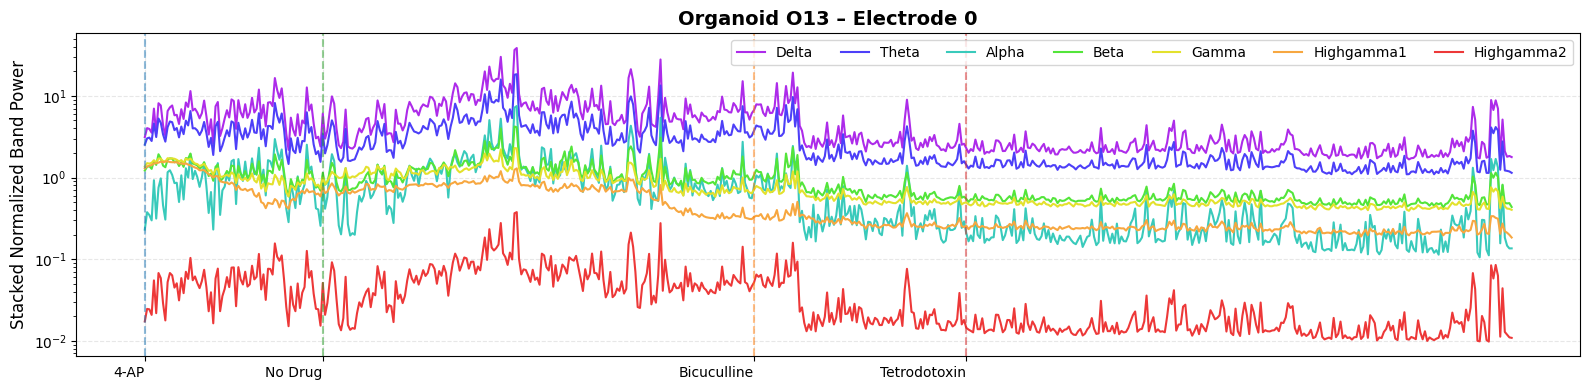

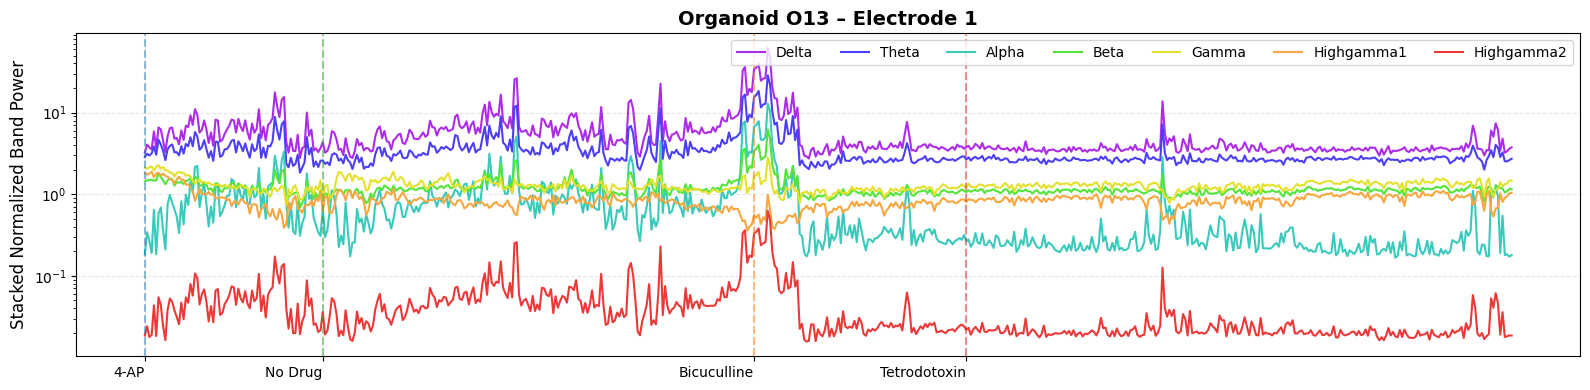

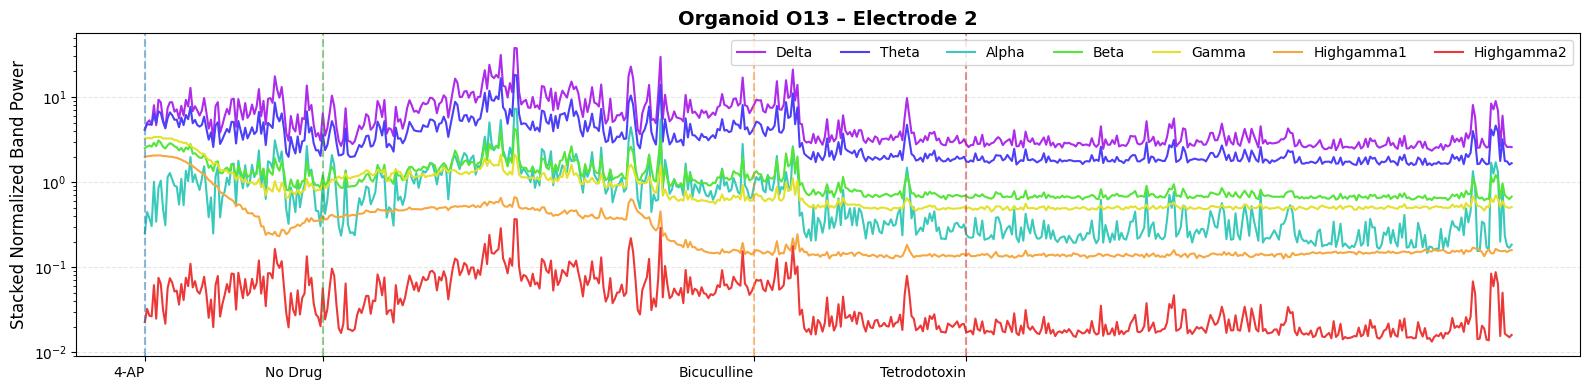

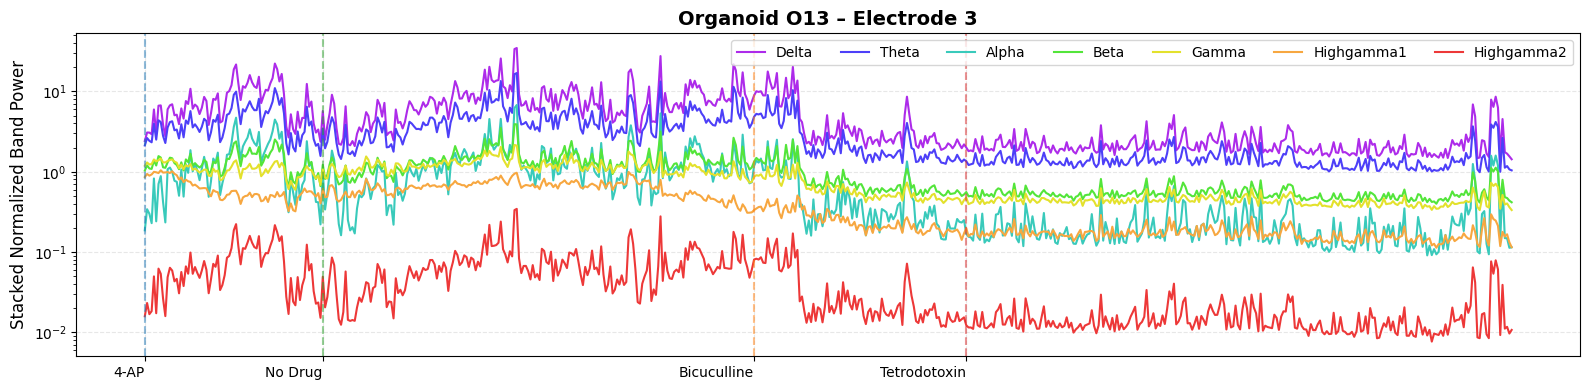

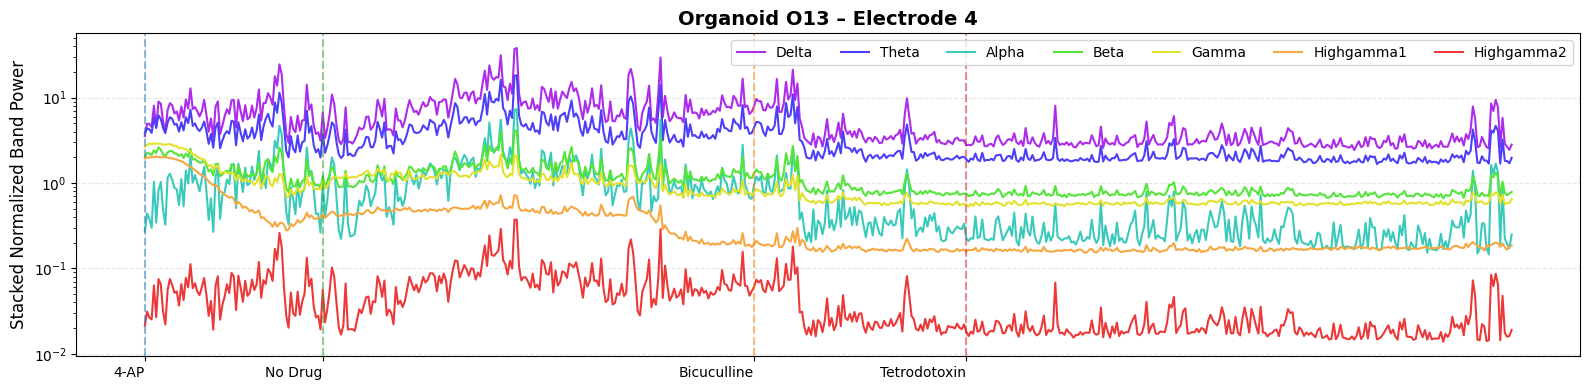

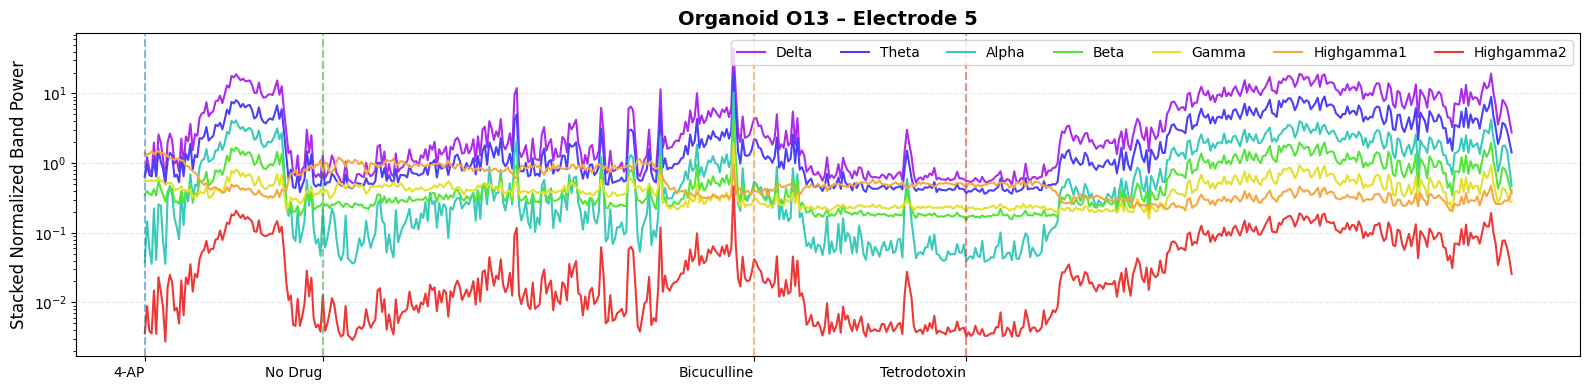

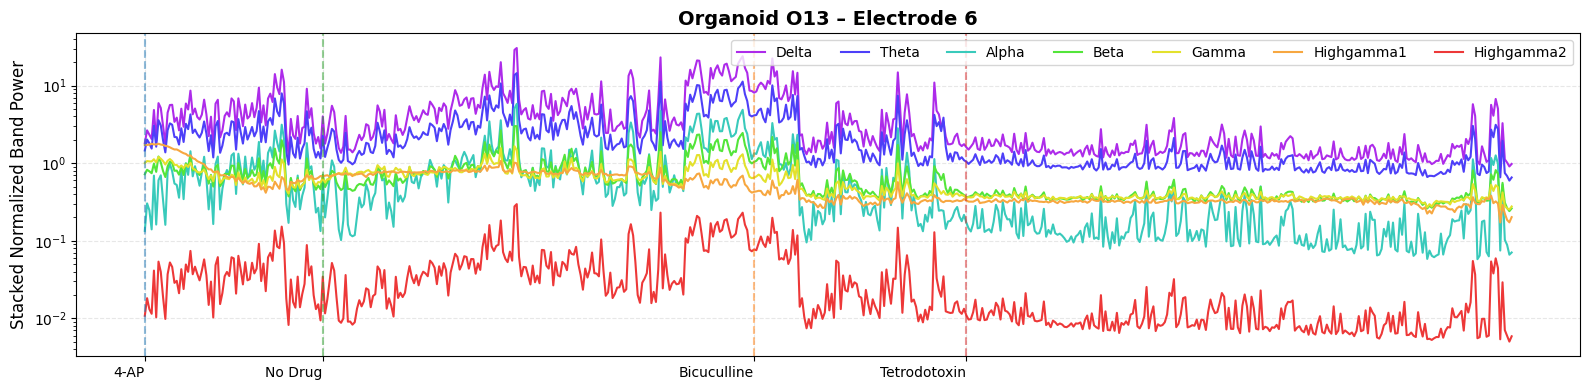

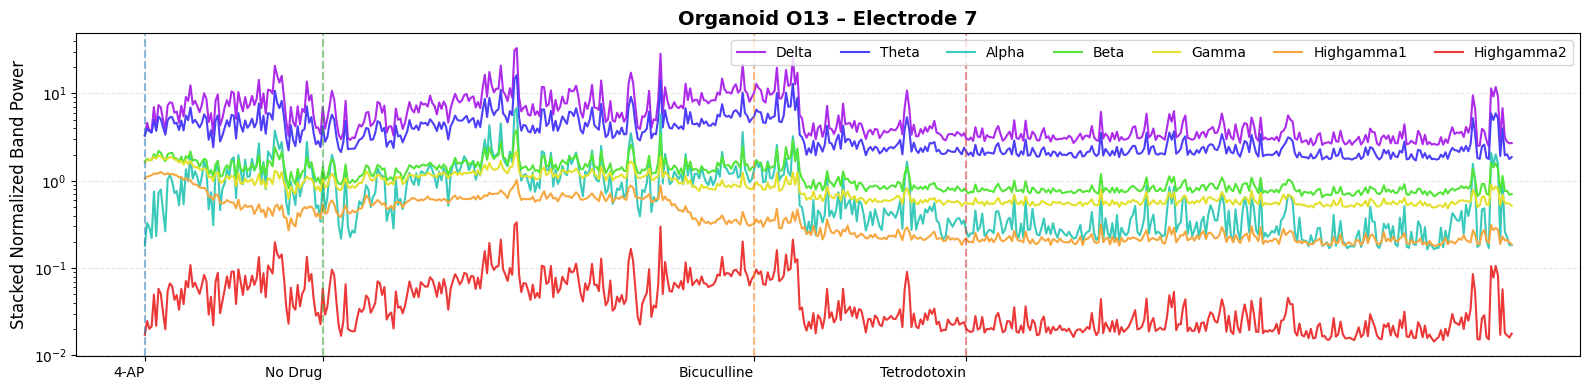

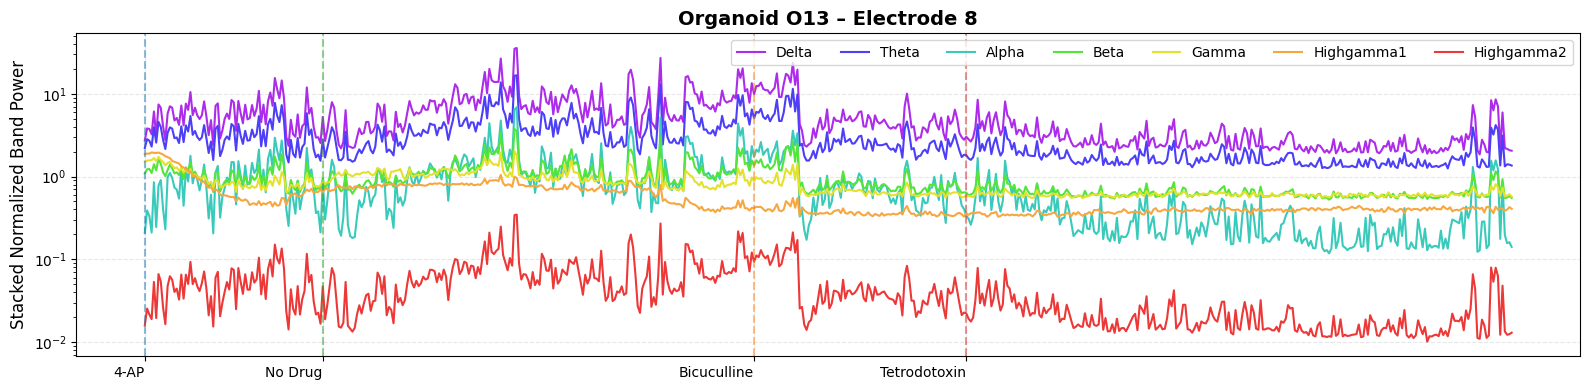

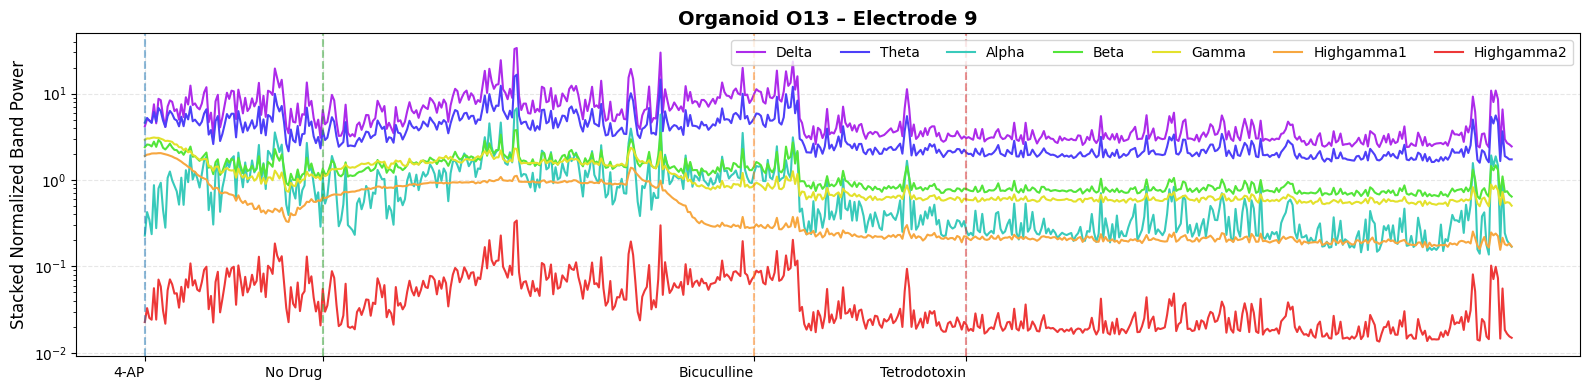

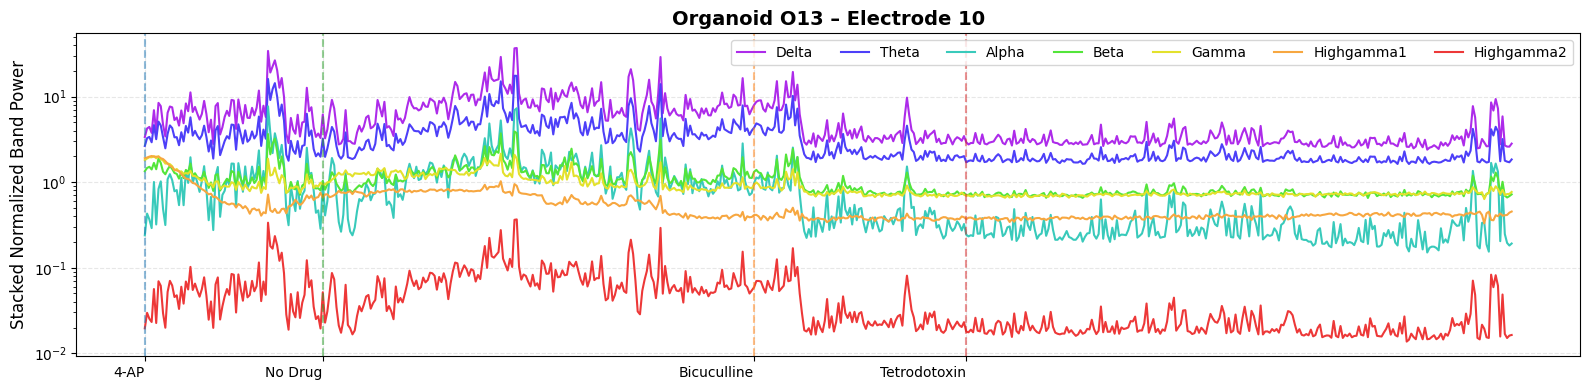

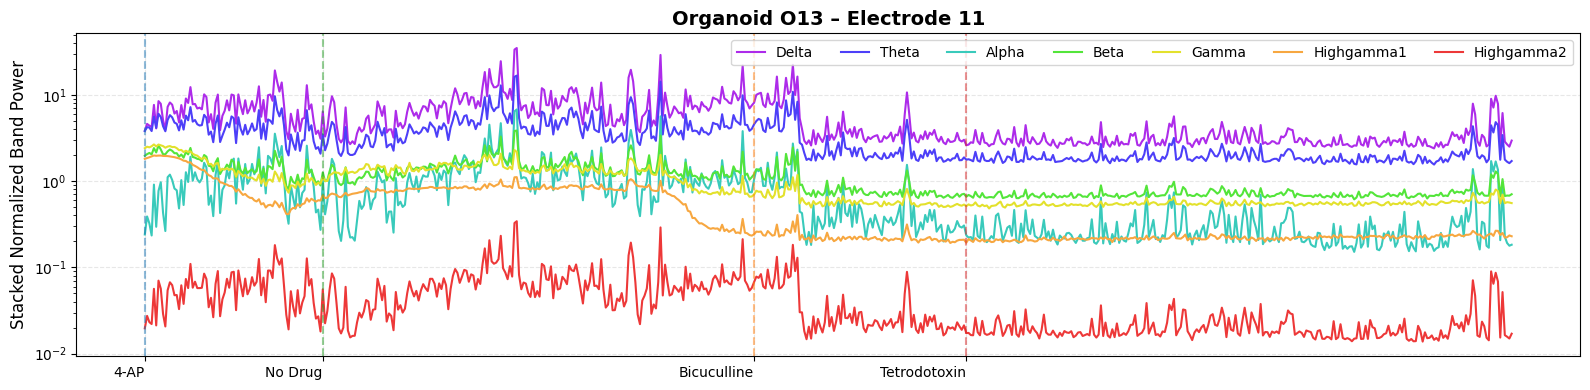

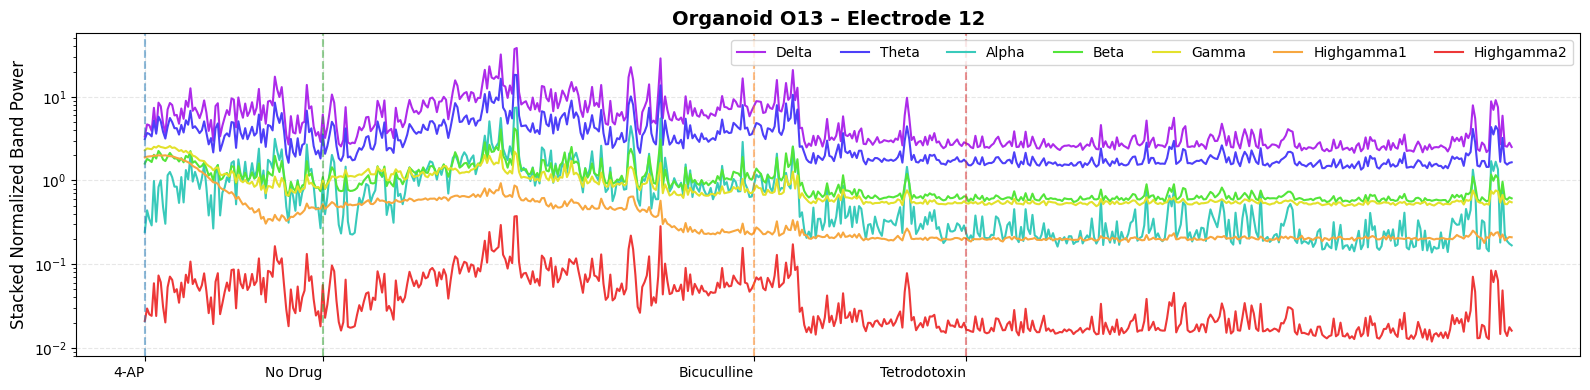

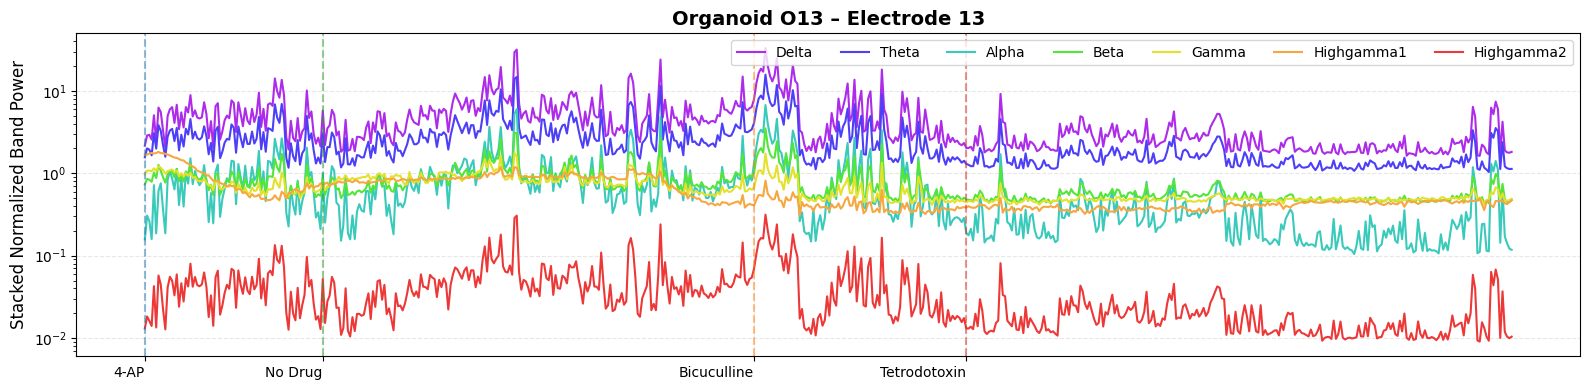

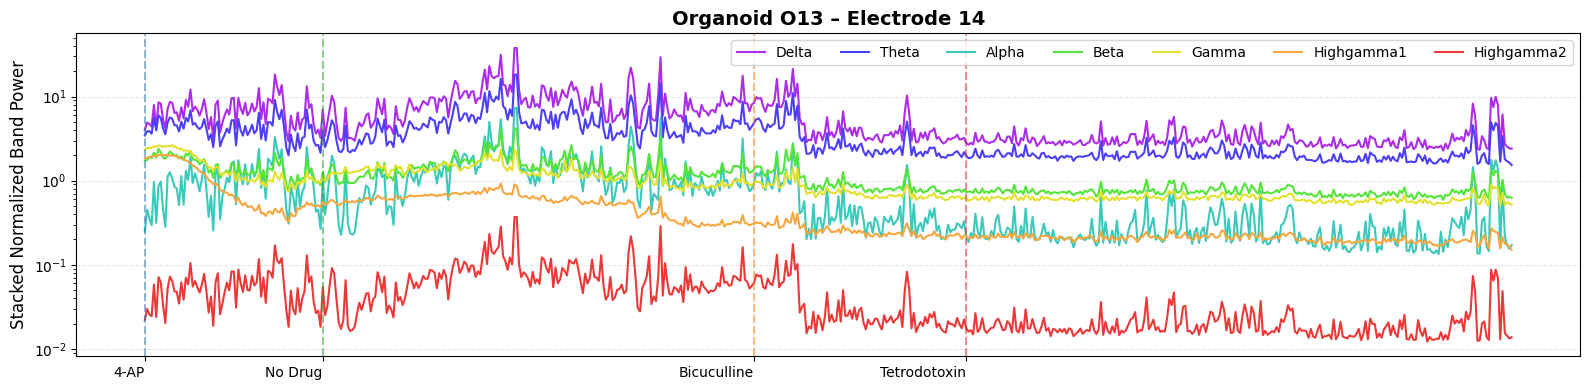

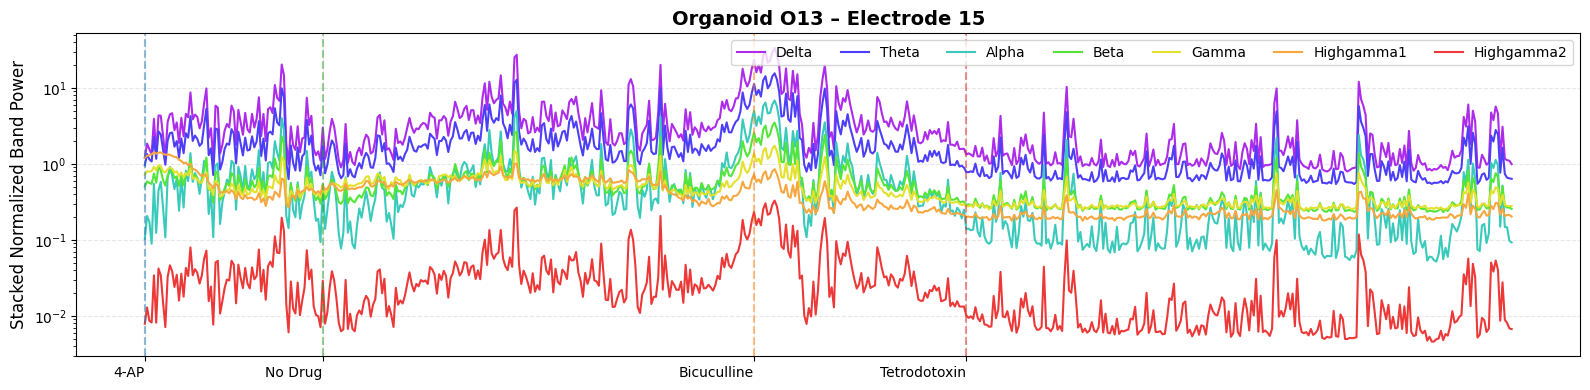

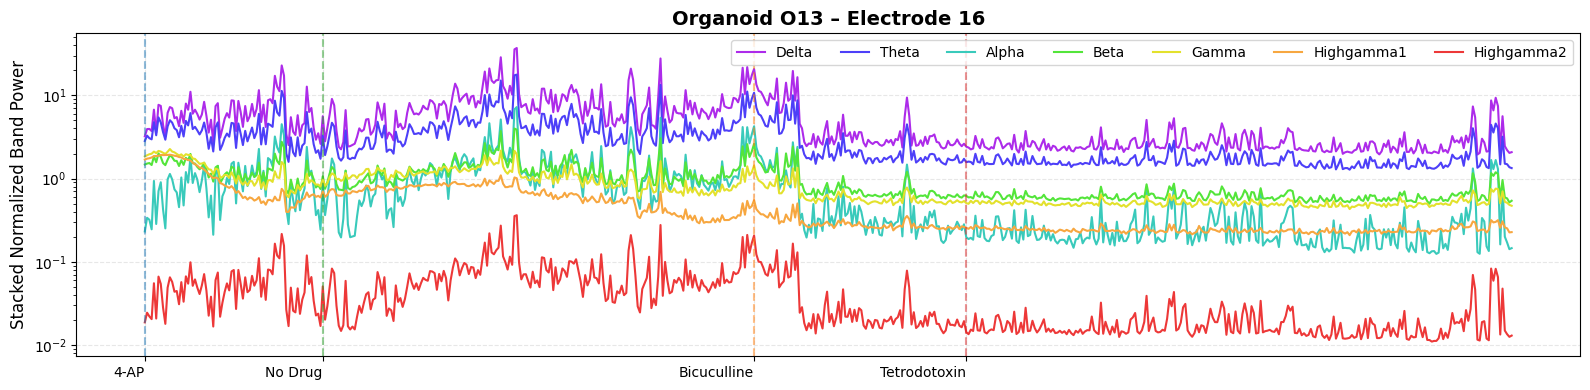

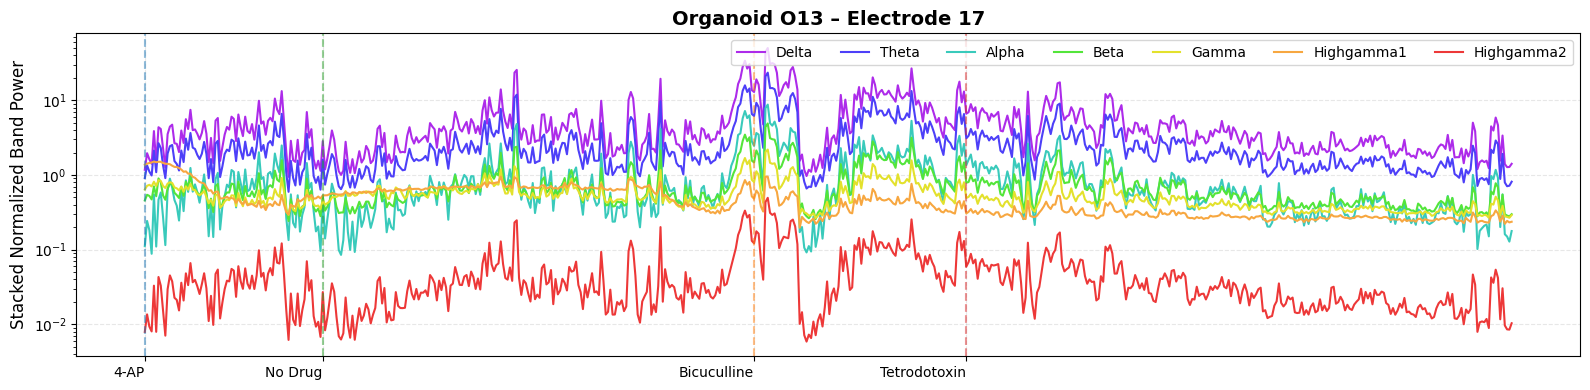

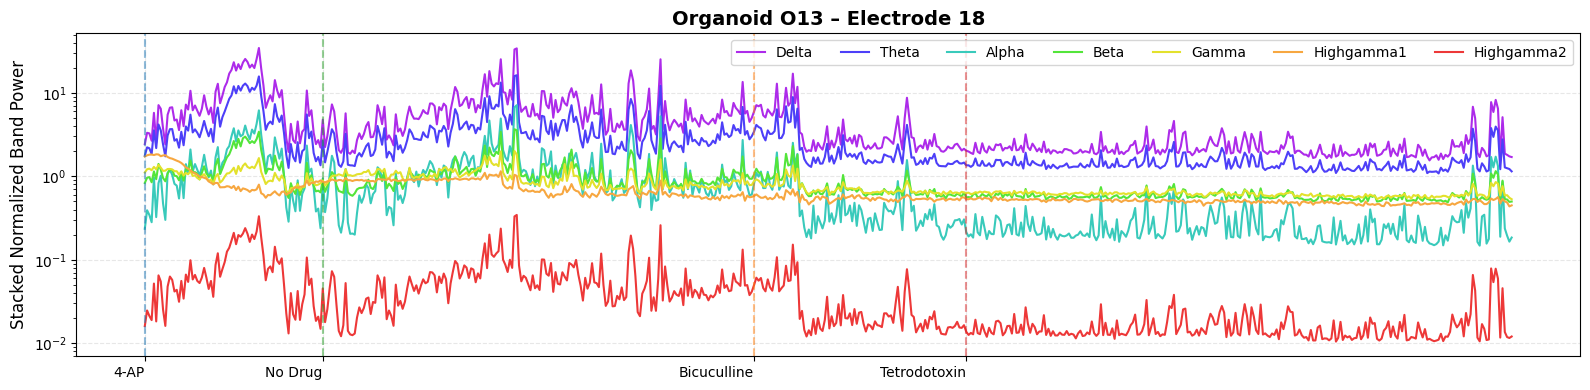

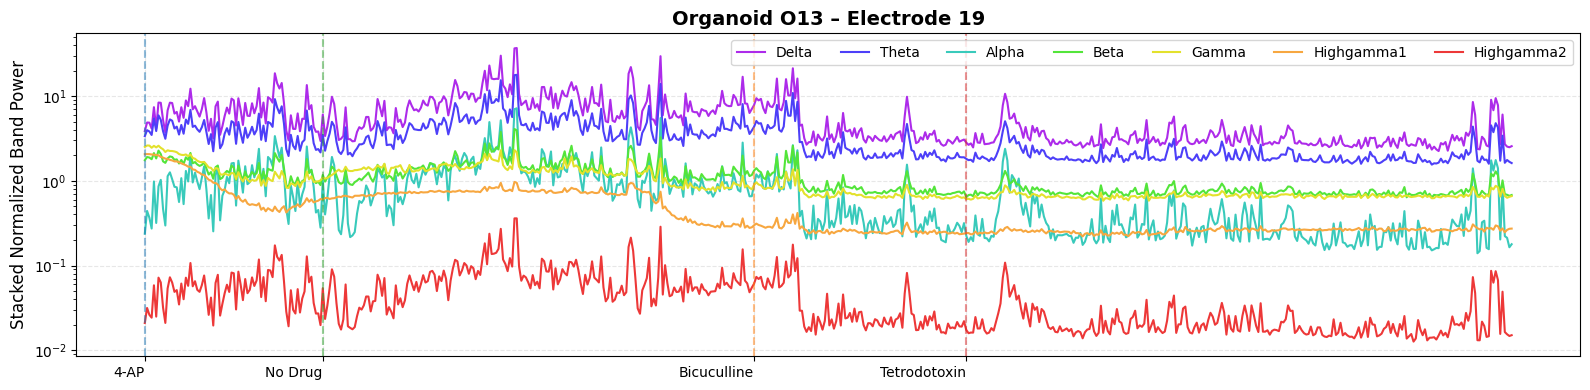

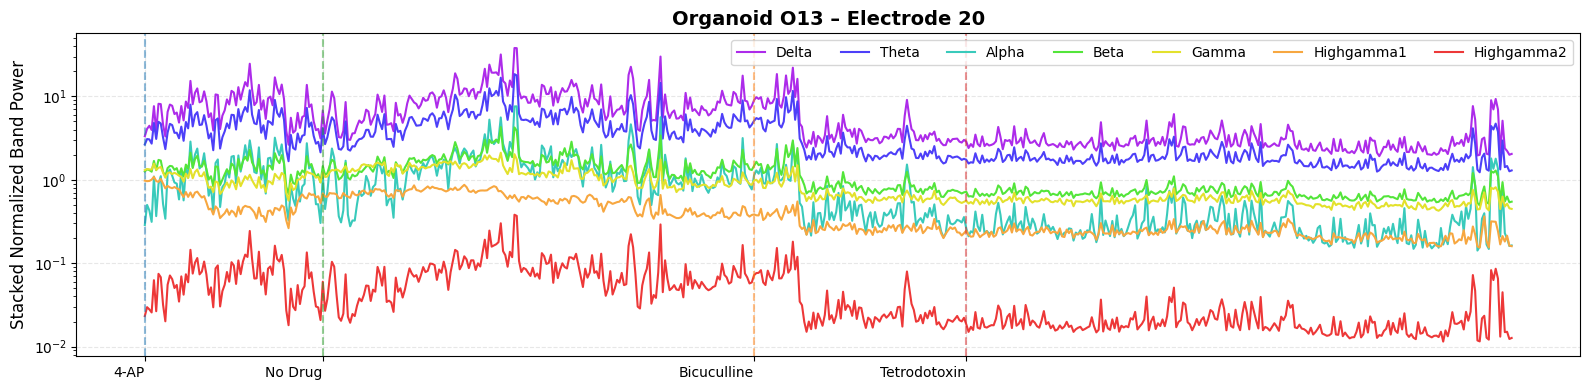

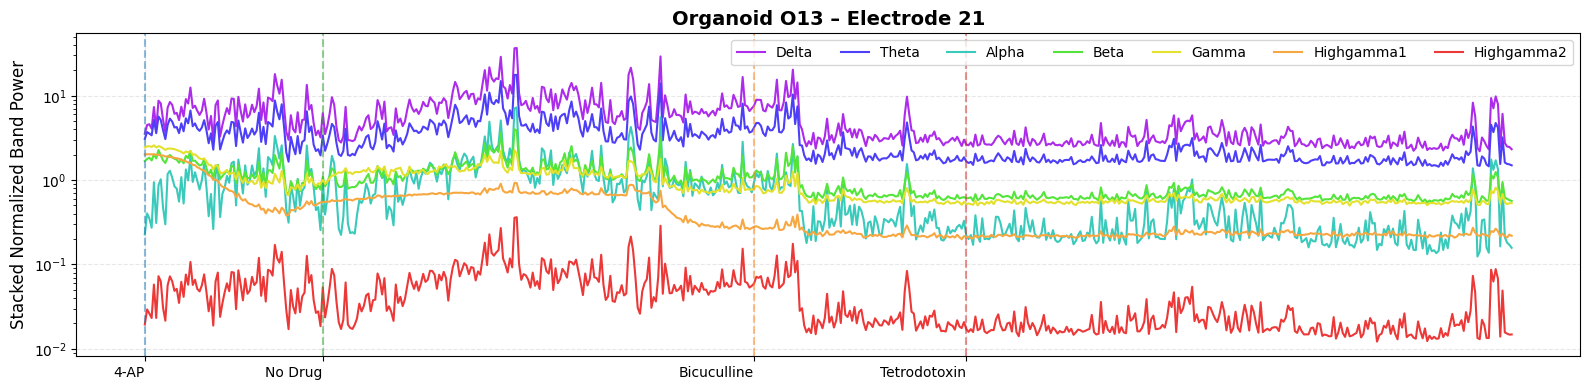

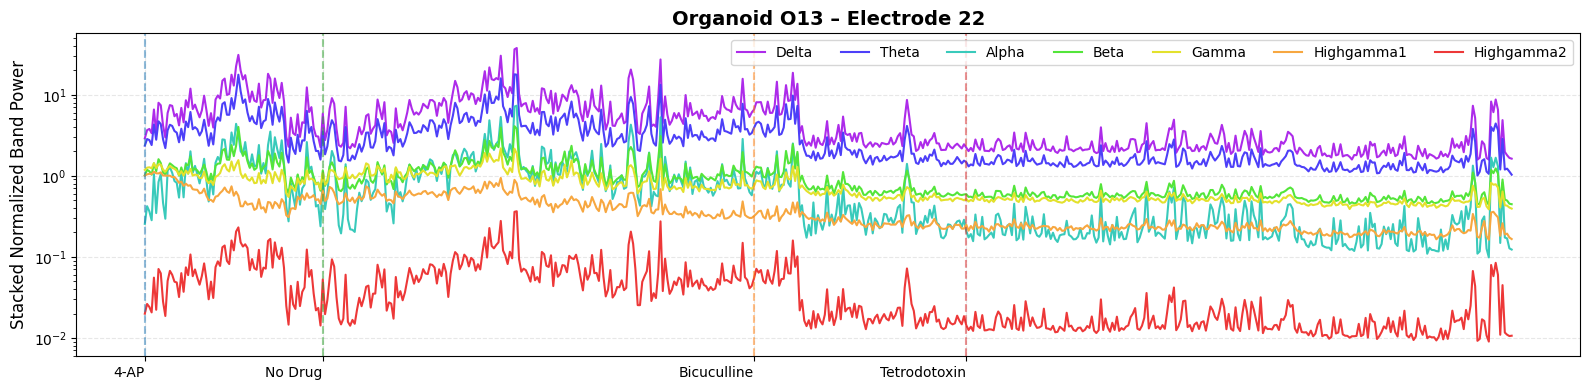

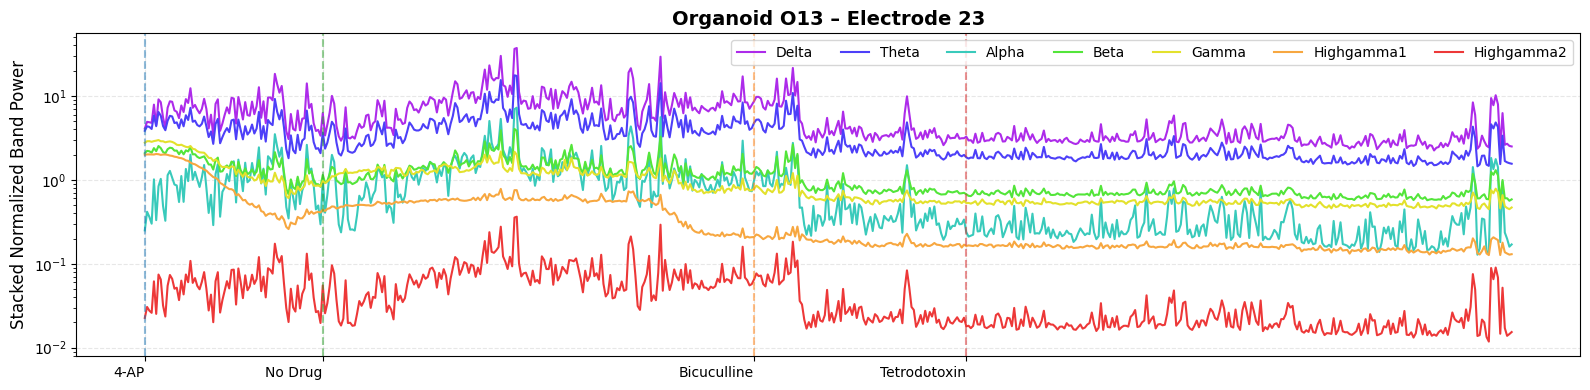

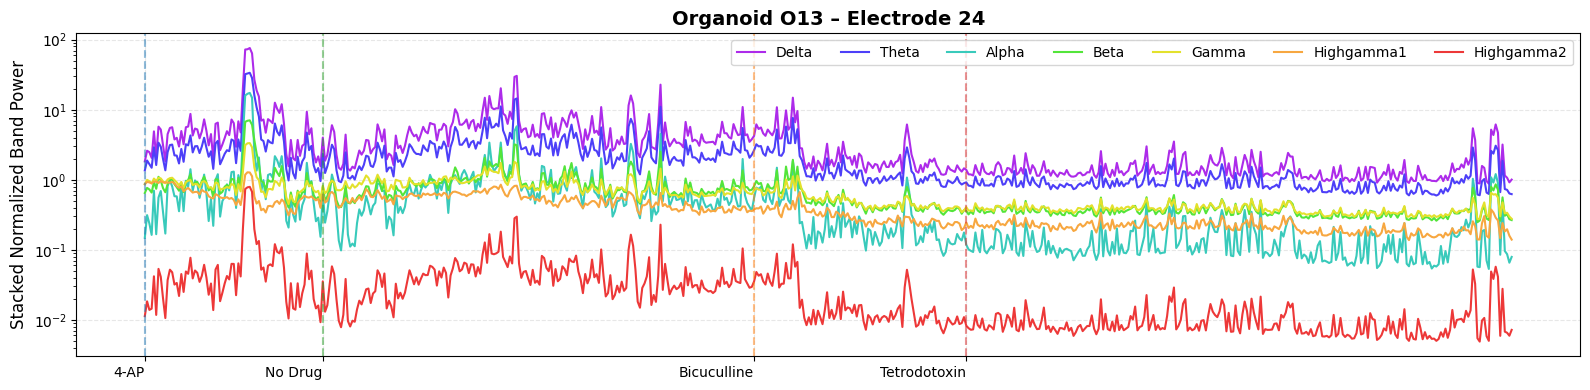

In [18]:
# --- Plot: One figure per electrode ---
for e in range(n_electrodes):
    power_trace = norm_power[:, :, e]  # (time, bands, electrodes)

    # Skip plotting if no data for the electrode (all values are NaN or flat)
    if np.isnan(power_trace).all() or np.nanstd(power_trace) < 1e-8:
        continue

    condensed_trace, condensed_time = condense_array(power_trace, time_axis, n_points)

    fig, ax = plt.subplots(figsize=(16, 4))
    ax.set_title(
        f"Organoid {organoid_id} – Electrode {e}",
        fontsize=14,
        fontweight="bold",
    )

    for b in range(n_bands):
        trace = condensed_trace[:, b]
        valid_mask = ~np.isnan(trace)
        ax.plot(
            condensed_time[valid_mask],
            trace[valid_mask] * band_log_offsets[b],
            color=lfp_colors[b],
            label=lfp_labels[b],
        )

    # Replace x-axis labels with drug names and add vertical lines
    drug_ticks = []
    drug_labels = []

    for drug, start_hr in drug_first_occurrence.items():
        closest_idx = np.argmin(np.abs(condensed_time - start_hr))
        label_time = condensed_time[closest_idx]

        drug_ticks.append(label_time)
        drug_labels.append(drug)

        # Add vertical dashed line
        ax.axvline(label_time, color=drug_colors[drug], linestyle="--", alpha=0.5)

    # Apply drug names as x-axis tick labels
    ax.set_xticks(drug_ticks)
    ax.set_xticklabels(drug_labels, ha="right", fontsize=10)

    ax.set_yscale("log")
    ax.set_ylabel("Stacked Normalized Band Power", fontsize=12)
    ax.grid(True, linestyle="--", alpha=0.3)
    ax.legend(loc="upper right", ncol=7, fontsize=10)
    plt.tight_layout()
    plt.show()
